In [1]:
from funcs.HelperFuncs import *
from funcs.CSIFuncs import *
from funcs.WLANFuncs import *

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Setting configs


In [2]:
# Directory storing the CSI and WLAN captures
resources_dir = "/Volumes/tim_details/tim_honours/CAPTURES"

# Directory to save plots to
plt_dir = "/Users/timothylee/Desktop/Uni/Yr5/Honours/honours_thesis/figures/plt_figs/"

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_seq = plt.get_cmap("viridis")
cmap_cycl = plt.get_cmap("twilight")
cmap_qual = plt.get_cmap("Pastel1")


## Using example captures for initial analysis


In [9]:
devices = [
    "client_pc_200",
    "client_pi_200",
]

videos = [
    "v=A3gUpodXMv0",
    "v=gxxqdrrpgZc",
    "v=mkWKZWMokdI",
    "v=NSW5u1RTxEA",
]

instances = [
    "cap_1",
    "cap_10",
    "cap_50",
    "cap_70",
    "cap_80",
]

i = 1
j = 2
k = 2

## Comparing WLAN data across captures

We want low intra-class distance and high inter-class distance.


In [4]:
# TODO: TRY WITH frame.time_epoch
# Function to return WLAN DF characteristics binned by time
def bin_wlan_df(wlan_df, interval):
    # Generating time-bins
    time_vect = wlan_df[
        "frame.time_relative"
    ]  # Binning the relative seconds from start
    # Making list of bins
    bins = np.arange(
        np.floor(time_vect.min()),
        np.ceil(time_vect.max()) + interval,
        interval,
    )
    # Adding binned category column to data
    wlan_df["time_bin"] = pd.cut(
        time_vect,
        bins=bins,
        include_lowest=True,
        labels=bins[:-1],
    )

    # Grouping and aggregating data on time bins
    agg_dict = {
        "frame.len": "count",
        "frame.len": "sum",
        "ip.len": "sum",
    }
    df_binned = wlan_df.groupby("time_bin").agg(agg_dict)
    # Ensuring that there are all timebins (even if some rows are empty)
    df_binned = (
        df_binned.reset_index()
        .merge(pd.Series(bins, name="time_bin"), on="time_bin", how="right")
        .set_index("time_bin")
        .sort_index()
    )
    # Calculating cumulative sums down the columns
    df_binned_cumsum = df_binned.apply(np.nancumsum, axis=0)
    df_binned = pd.concat(
        [
            df_binned,
            df_binned_cumsum.add_suffix("_cumsum"),
        ],
        axis=1,
    )
    return df_binned


(8, 4)


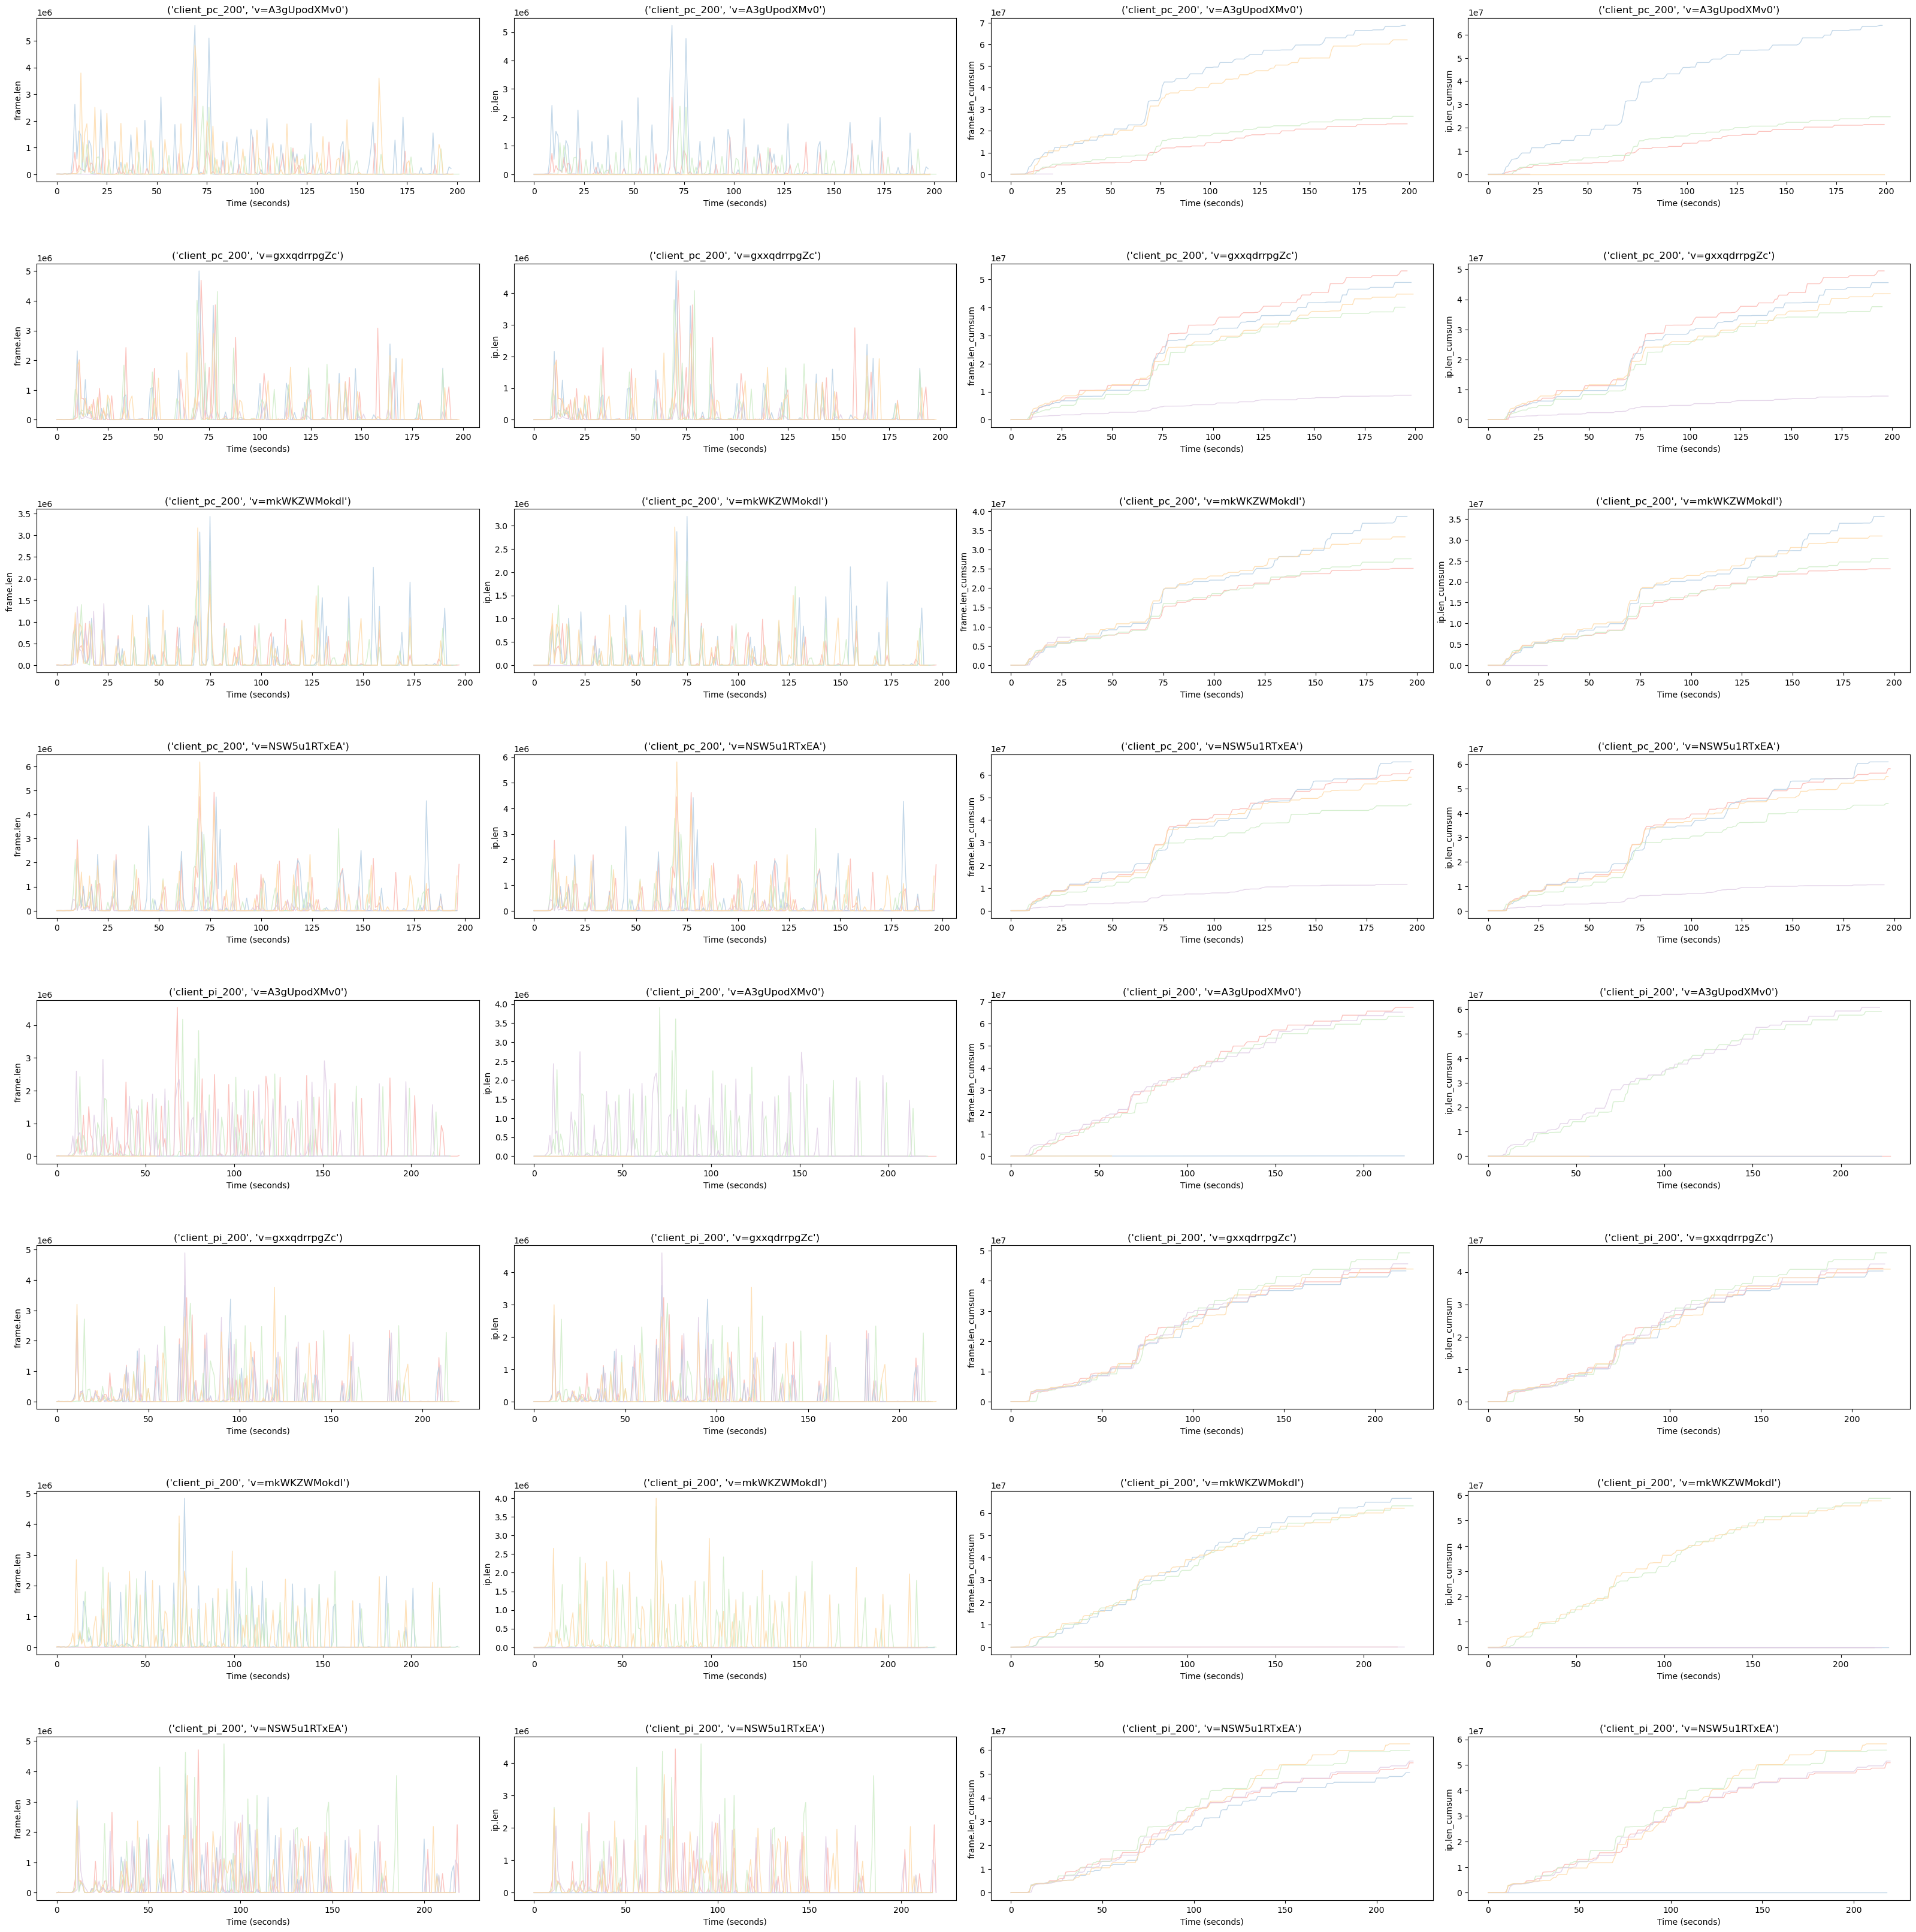

In [5]:
# Binning WLAN DFs
interval = 1  # Binning interval in seconds
# TODO: try out combination of devices, locations, and videos
classes = np.array(np.meshgrid(devices, videos)).T.reshape(-1, 2)
wlan_binned_dfs = {}
# Saving list of DF instances for each combination in dict element
for i, j in classes:
    # Declaring the class combination
    comb = (i, j)
    # Making list for DF instances
    wlan_binned_dfs[comb] = []
    for k in instances:
        # Reading WLAN DF
        wlan_df = pd.read_hdf(
            os.path.join(resources_dir, i, j, "wlan_h5", f"{k}.h5"),
            key=H5_WLAN_KEY,
            mode="r",
        )
        # Saving binned WLAN DF to dict
        wlan_binned_dfs[comb].append(bin_wlan_df(wlan_df, interval))


# Visualising data
# Rows are classes and columns are features
nrows = len(wlan_binned_dfs)  # classes
ncols = list(wlan_binned_dfs.values())[0][0].shape[1]  # features
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(32, 32),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
print(axes.shape)
for i, (labels, wlan_binned_ls) in enumerate(wlan_binned_dfs.items()):
    for j, wlan_binned in enumerate(wlan_binned_ls):
        for k in np.arange(wlan_binned.shape[1]):
            axes[i, k].plot(
                wlan_binned.index,
                wlan_binned.iloc[:, k],
                label=i,
                color=cmap_qual(j),
                alpha=0.8,
                linewidth=1,
            )
            # axes[i, k].set_title(f"{i})", loc="left", fontsize="medium")
            axes[i, k].set_title(labels)
            axes[i, k].set_xlabel("Time (seconds)")
            axes[i, k].set_ylabel(wlan_binned.columns[k])

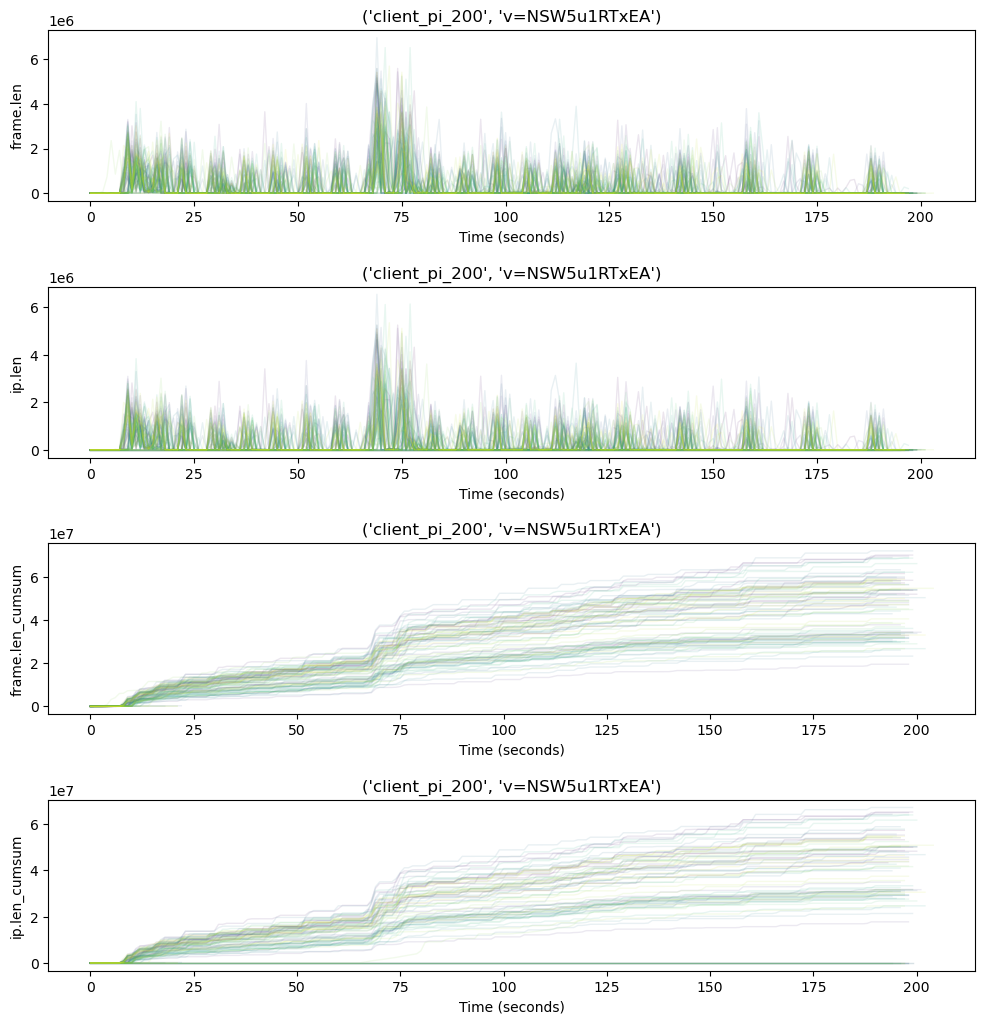

In [6]:
# Focussing only on a single class combination
# Binning WLAN DFs
interval = 1  # Binning interval in seconds
focus_class = os.path.join(resources_dir, devices[0], videos[0])
focus_instances = os.listdir(os.path.join(focus_class, "wlan_h5"))
wlan_binned_ls = []
# for k in instances:
for k in focus_instances:
    # Reading WLAN DF
    wlan_df = pd.read_hdf(
        # os.path.join(focus_dir, "wlan_h5", f"{k}.h5"),
        os.path.join(focus_class, "wlan_h5", f"{k}"),
        key=H5_WLAN_KEY,
        mode="r",
    )
    # Saving binned WLAN DF to dict
    wlan_binned_ls.append(bin_wlan_df(wlan_df, interval))

# Visualising data as lines
# Rows are features
nrows = list(wlan_binned_dfs.values())[0][0].shape[1]  # features
fig, axes = plt.subplots(
    nrows=nrows,
    figsize=(10, 10),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
for i, wlan_binned in enumerate(wlan_binned_ls):
    for j in np.arange(wlan_binned.shape[1]):
        axes[j].plot(
            wlan_binned.index,
            wlan_binned.iloc[:, j],
            label=i,
            color=cmap_seq(i/len(focus_instances)),
            alpha=0.1,
            linewidth=1,
        )
        # axes[i].set_title(f"{i})", loc="left", fontsize="medium")
        axes[j].set_title(labels)
        axes[j].set_xlabel("Time (seconds)")
        axes[j].set_ylabel(wlan_binned.columns[j])


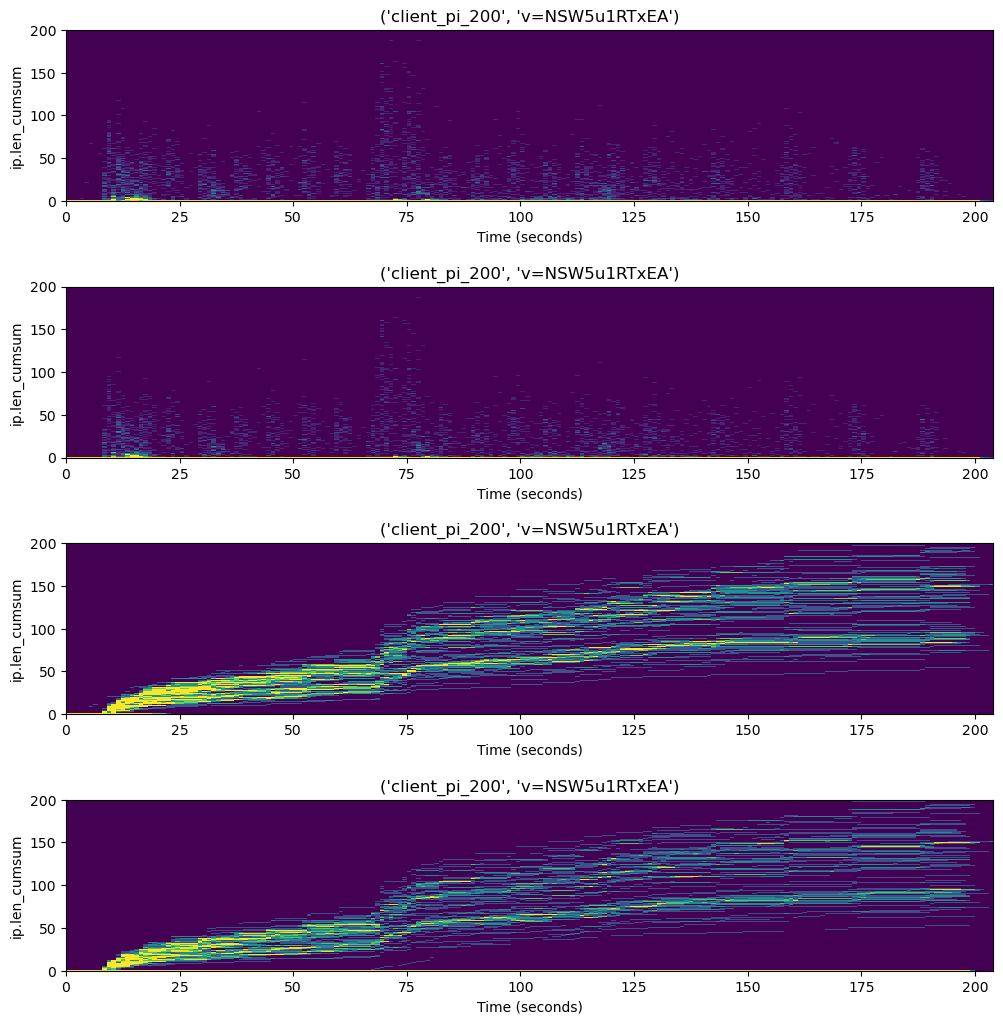

In [7]:
wlan_binned_all = pd.concat(wlan_binned_ls, axis=0)
# Filling in missing data
wlan_binned_all = wlan_binned_all.fillna(0)
# wlan_binned_all = wlan_binned_all.interpolate(method="linear", axis=0)

# Visualising data as 2D frequency heatmaps
# Rows are features
nrows = list(wlan_binned_dfs.values())[0][0].shape[1]  # features
fig, axes = plt.subplots(
    nrows=nrows,
    figsize=(10, 10),
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
for i, col_name in list(enumerate(wlan_binned.columns)):
    # Making 2D histogram frequency distribution with (200, # intervals) bins
    H, xedges, yedges = np.histogram2d(
        wlan_binned_all[col_name],
        wlan_binned_all.index,
        bins=(200, int(wlan_binned_all.index.max()/interval)),
    )
    axes[i].pcolormesh(
        H,
        cmap=cmap_seq,
        vmax=H.mean() + 2 * H.std(),
    )
    # axes[i].set_title(f"{i})", loc="left", fontsize="medium")
    axes[i].set_title(labels)
    axes[i].set_xlabel("Time (seconds)")
    axes[i].set_ylabel(wlan_binned.columns[j])

## Combining and Comparing WLAN and CSI data for each capture

Observations are:

- There are MANY more WLAN packets than CSI packets for each capture
- The relative bursts are the same for the WLAN and CSI captures. This is easiest visualised, where "horizontally stretching" the CSI plot of cumulative number of frames through time would fit the corresponding WLAN plot for the cumulative number of frames through time.


In [10]:
# READING DATAFRAMES

# Getting filepaths
wlan_fp = os.path.join(
    resources_dir, devices[i], videos[j], "wlan_h5", f"{instances[k]}.h5"
)
csi_fp = os.path.join(
    resources_dir, devices[i], videos[j], "csi_h5", f"{instances[k]}.h5"
)
# Reading dataframes
wlan_df = pd.read_hdf(wlan_fp, key=H5_WLAN_KEY, mode="r")
csi_df = pd.read_hdf(csi_fp, key=H5_CSI_KEY, mode="r")

# Displaying dataframes
display(wlan_df)
display(csi_df)

,frame.time_epoch,frame.time_relative,frame.len,wlan_radio.signal_dbm,wlan.fc.version,wlan.fc.type,wlan.fc.subtype,wlan.frag,wlan.seq,wlan.da,wlan.sa,ip.proto,ip.src,ip.dst,ip.len,srcport,dstport,is_upstream
frame.number,,,,,,,,,,,,,,,,,,
1,1693942751.124928,0.000000,45,-51,0,0,10,0,227,74:83:c2:c1:6d:15,d8:3a:dd:21:b8:2b,0,0,0,0,0,0,True
2,1693942751.125645,0.000717,45,-50,0,0,10,0,227,74:83:c2:c1:6d:15,d8:3a:dd:21:b8:2b,0,0,0,0,0,0,True
3,1693942751.126071,0.001143,45,-55,0,2,12,0,228,74:83:c2:c1:6d:15,d8:3a:dd:21:b8:2b,0,0,0,0,0,0,True
4,1693942752.381347,1.256419,257,-48,0,0,4,0,259,ff:ff:ff:ff:ff:ff,d8:3a:dd:21:b8:2b,0,0,0,0,0,0,True
5,1693942752.383591,1.258663,268,-54,0,0,5,0,2742,d8:3a:dd:21:b8:2b,34:12:98:07:df:82,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52987,1693942978.422077,227.297149,134,-54,0,2,8,0,3916,34:12:98:02:02:14,d8:3a:dd:21:b8:2b,6,10.0.1.29,142.250.204.2,52,0,0,True
52988,1693942978.426878,227.301950,124,-58,0,2,8,0,1286,d8:3a:dd:21:b8:2b,34:12:98:02:02:14,6,34.104.35.123,10.0.1.29,52,0,0,False
52989,1693942978.428059,227.303131,134,-54,0,2,8,0,3917,34:12:98:02:02:14,d8:3a:dd:21:b8:2b,6,10.0.1.29,34.104.35.123,52,0,0,True


,frame.time_epoch,frame.time_relative,fctl,seqn,fragn,csi_0_r,csi_0_i,csi_1_r,csi_1_i,csi_2_r,...,csi_59_r,csi_59_i,csi_60_r,csi_60_i,csi_61_r,csi_61_i,csi_62_r,csi_62_i,csi_63_r,csi_63_i
frame.number,,,,,,,,,,,,,,,,,,,,,
1,1693942757.372217,0.000000,88,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1693942757.380696,0.008479,88,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1693942757.420732,0.048515,88,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1693942757.471034,0.098817,88,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1693942757.513267,0.141050,88,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,1693942978.002988,220.630771,88,3908,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10427,1693942978.048128,220.675911,94,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10428,1693942978.048238,220.676021,88,3909,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


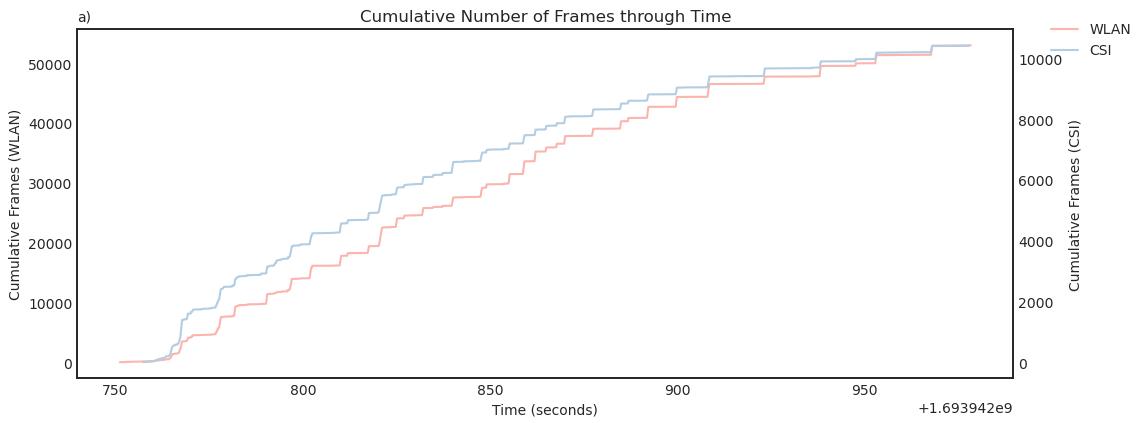

In [12]:
# COMPARING THE CUMULATIVE NUMBER OF FRAMES THROUGH TIME OF A CAPTURE'S CSI AND WLAN

# TODO: NEED TO TRY WITH frame.time_epoch - THIS WILL BE ALIGNED

# PLOTTING WLAN AND CSI ON SAME AXES WITH DIFFERENT SCALES
# with plt.style.context(fig_style):
with plt.style.context("seaborn-v0_8-white"):
    # Making figure
    fig, ax1 = plt.subplots(figsize=(10, 4))
    fig.tight_layout()

    # PLOTTING WLAN
    ax1.plot(
        wlan_df["frame.time_epoch"],
        wlan_df.index,
        label="WLAN",
        color=cmap_qual(0),
    )
    ax1.set_ylabel("Cumulative Frames (WLAN)")

    # PLOTTING WLAN
    # Create a second set of y-axes for the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(
        csi_df["frame.time_epoch"],
        csi_df.index,
        label="CSI",
        color=cmap_qual(1),
    )
    ax2.set_ylabel("Cumulative Frames (CSI)")
    # Set legend position (or remove)

    # CUSTOMISING APPEARANCE
    # Set axis titles
    ax1.set_title("a)", loc="left", fontsize="medium")
    ax1.set_title("Cumulative Number of Frames through Time")
    ax1.set_xlabel("Time (seconds)")
    # Set legend position (or remove)
    fig.legend(loc="upper left", bbox_to_anchor=(1, 1))
    # ax1.legend(loc="upper left")

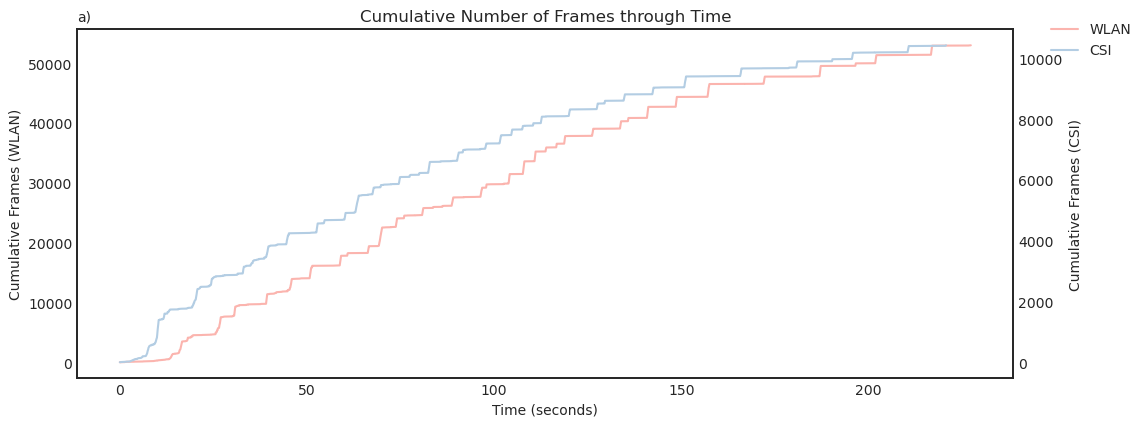

In [13]:
# COMPARING THE CUMULATIVE NUMBER OF FRAMES THROUGH TIME OF A CAPTURE'S CSI AND WLAN

# TODO: NEED TO TRY WITH frame.time_epoch - THIS WILL BE ALIGNED

# PLOTTING WLAN AND CSI ON SAME AXES WITH DIFFERENT SCALES
# with plt.style.context(fig_style):
with plt.style.context("seaborn-v0_8-white"):
    # Making figure
    fig, ax1 = plt.subplots(figsize=(10, 4))
    fig.tight_layout()

    # PLOTTING WLAN
    ax1.plot(
        wlan_df["frame.time_relative"],
        wlan_df.index,
        label="WLAN",
        color=cmap_qual(0),
    )
    ax1.set_ylabel("Cumulative Frames (WLAN)")

    # PLOTTING WLAN
    # Create a second set of y-axes for the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(
        csi_df["frame.time_relative"],
        csi_df.index,
        label="CSI",
        color=cmap_qual(1),
    )
    ax2.set_ylabel("Cumulative Frames (CSI)")
    # Set legend position (or remove)

    # CUSTOMISING APPEARANCE
    # Set axis titles
    ax1.set_title("a)", loc="left", fontsize="medium")
    ax1.set_title("Cumulative Number of Frames through Time")
    ax1.set_xlabel("Time (seconds)")
    # Set legend position (or remove)
    fig.legend(loc="upper left", bbox_to_anchor=(1, 1))
    # ax1.legend(loc="upper left")